# Boundary Effects

This Jupyter Notebook is nearly identical to that from Figure 6. For this, we simulated in a larger area 300x300 units (rather than 100x100) and sampled individuals from only the center of the area. "process.py" runs sparg on a tree sequence output by SLiM. This generates the random_ancestors_1000_effective_dispersal.csv file which is used to create accuracy plots. This confirms that the patterns remain the same even under this new simulation, which should have helped to reduce the boundary effects.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import scipy.stats as st
import tskit
import sparg

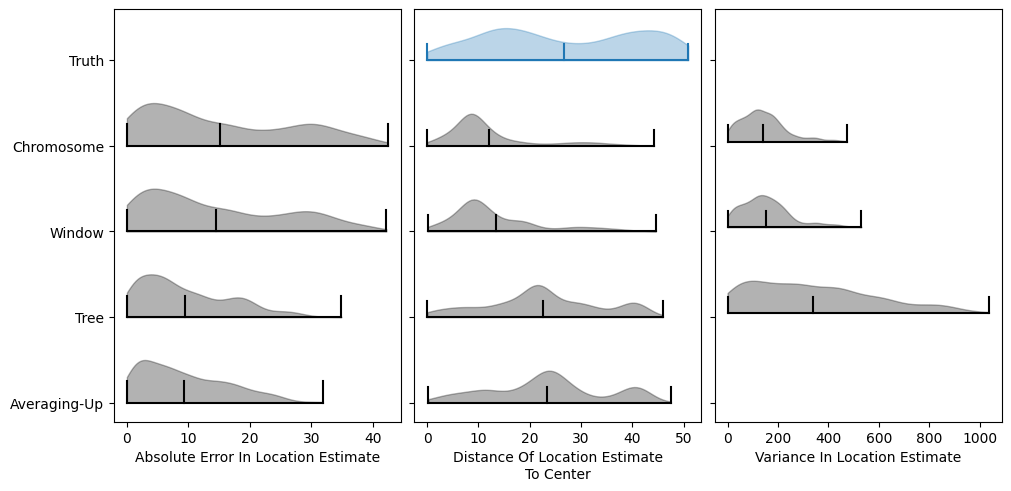

In [5]:
random_ancestors = pd.read_csv("random_ancestors_1000_effective_dispersal.csv")

gap = 0.05

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, layout="constrained", sharey=True)

vp0 = ax0.violinplot([
    random_ancestors["midpoint_abs_error"],
    random_ancestors["window_0_abs_error"],
    random_ancestors["window_100_abs_error"],
    random_ancestors["arg_abs_error"]
], showmeans=True, vert=False, side="high", widths=1)
ax0.set_xlabel("Absolute Error In Location Estimate")

for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp = vp0[partname]
    vp.set_edgecolor("black")
    
for pc in vp0['bodies']:
    pc.set_color("black")

vp2 = ax1.violinplot([
    random_ancestors["midpoint_dist_to_center"],
    random_ancestors["window_0_dist_to_center"],
    random_ancestors["window_100_dist_to_center"],
    random_ancestors["arg_dist_to_center"]
], showmeans=True, vert=False, side="high", widths=0.75)
vp2_true = ax1.violinplot([
    random_ancestors["true_dist_to_center"]
], showmeans=True, vert=False, side="high", widths=0.75, positions=[5])
ax1.set_xlabel("Distance Of Location Estimate\nTo Center")

for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp2[partname].set_edgecolor("black")
    vp2_true[partname].set_edgecolor("#1f77b4")

for pc in vp2["bodies"]:
    pc.set_color("black")
for pc in vp2_true["bodies"]:
    pc.set_color("#1f77b4")

vp1_x = ax2.violinplot([
    random_ancestors["window_0_variance_in_estimated_location_0"],
    random_ancestors["window_100_variance_in_estimated_location_0"],
    random_ancestors["arg_variance_in_estimated_location_0"],
], showmeans=True, vert=False, side="high", widths=0.75, positions=[2+gap,3+gap,4+gap])
ax2.set_xlabel("Variance In Location Estimate")

for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp1_x[partname].set_edgecolor("black")

for pc in vp1_x["bodies"]:
    pc.set_color("black")

plt.yticks([5,4,3,2,1], ["Truth", "Chromosome", "Window", "Tree", "Averaging-Up"])
fig.set_figwidth(10)
plt.savefig("OneDimension.svg")
plt.show()